## Setup

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import SqueezeNet1_1_Weights
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split

cudnn.benchmark = True
plt.ion()

Load data and create Dataloaders

In [45]:
from utils import SymbolDataset, encode_labels

data_dir = 'symbols.npz'
data = np.load(data_dir)
images = data['images']
labels = data['labels']

class_names, labels_nums = encode_labels(labels)

images_tensor = torch.tensor(images).float()

# NOTE: maybe try different mean and stds?
# mean and std from imagenet are as follows:
#  - mean = 0.4453
#  - std  = 0.2692

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
}

# initialize symbol dataset training splits
dataset = SymbolDataset(images, labels_nums, transforms=data_transforms['train'])
print(images.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# initialize dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=1024, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(356990, 32, 32)


Visualize a batch of training data

torch.Size([1024, 1, 32, 32])
torch.Size([3, 4354, 274])


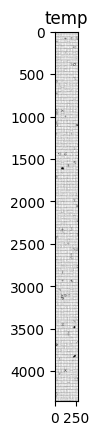

In [46]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title="temp")

## Model Training

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    if torch.cuda.is_available():
        model = model.cuda()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = np.repeat(inputs, 3, axis=1)
                    if torch.cuda.is_available():
                        inputs = inputs.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [64]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # if it errors here u probably have to do the same grayscale to rgb stacking i did earlier
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Summarize pre-trained ResNet18

In [50]:
from torchinfo import summary


model_ft = models.squeezenet1_1(weights=SqueezeNet1_1_Weights.IMAGENET1K_V1)
summary(model=model_ft, 
        verbose=0,
        input_size=(1024, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SqueezeNet (SqueezeNet)                       [1024, 3, 32, 32]    [1024, 1000]         --                   True
├─Sequential (features)                       [1024, 3, 32, 32]    [1024, 512, 1, 1]    --                   True
│    └─Conv2d (0)                             [1024, 3, 32, 32]    [1024, 64, 15, 15]   1,792                True
│    └─ReLU (1)                               [1024, 64, 15, 15]   [1024, 64, 15, 15]   --                   --
│    └─MaxPool2d (2)                          [1024, 64, 15, 15]   [1024, 64, 7, 7]     --                   --
│    └─Fire (3)                               [1024, 64, 7, 7]     [1024, 128, 7, 7]    --                   True
│    │    └─Conv2d (squeeze)                  [1024, 64, 7, 7]     [1024, 16, 7, 7]     1,040                True
│    │    └─ReLU (squeeze_activation)         [1024, 16, 7, 7]     [1024, 16, 7, 7]    

Modify last linear classification layer and freeze previous layers in preparation for transfer learning

In [51]:
for param in model_ft.parameters():
    param.requires_grad = False

# alter output size of last linear layer (fc)
num_ftrs = model_ft.classifier[1].in_channels
model_ft.classifier[1] = nn.Conv2d(num_ftrs, num_classes, kernel_size=(1,1), stride=(1,1))

model_ft = model_ft.to(device)

summary(model=model_ft, 
        verbose=0,
        input_size=(1024, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
SqueezeNet (SqueezeNet)                       [1024, 3, 32, 32]    [1024, 62]           --                   Partial
├─Sequential (features)                       [1024, 3, 32, 32]    [1024, 512, 1, 1]    --                   False
│    └─Conv2d (0)                             [1024, 3, 32, 32]    [1024, 64, 15, 15]   (1,792)              False
│    └─ReLU (1)                               [1024, 64, 15, 15]   [1024, 64, 15, 15]   --                   --
│    └─MaxPool2d (2)                          [1024, 64, 15, 15]   [1024, 64, 7, 7]     --                   --
│    └─Fire (3)                               [1024, 64, 7, 7]     [1024, 128, 7, 7]    --                   False
│    │    └─Conv2d (squeeze)                  [1024, 64, 7, 7]     [1024, 16, 7, 7]     (1,040)              False
│    │    └─ReLU (squeeze_activation)         [1024, 16, 7, 7]     [1024, 16, 7,

Initialize loss criterion and training optimizer

In [52]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training loop

In [53]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


train Loss: 2.4606 Acc: 0.2890
val Loss: 0.5029 Acc: 0.0902

Epoch 1/24
----------
train Loss: 2.1306 Acc: 0.3348
val Loss: 0.4860 Acc: 0.0944

Epoch 2/24
----------
train Loss: 2.0865 Acc: 0.3416
val Loss: 0.4787 Acc: 0.0973

Epoch 3/24
----------
train Loss: 2.0515 Acc: 0.3487
val Loss: 0.4659 Acc: 0.0987

Epoch 4/24
----------
train Loss: 2.0177 Acc: 0.3548
val Loss: 0.4615 Acc: 0.1009

Epoch 5/24
----------
train Loss: 2.0132 Acc: 0.3557
val Loss: 0.4613 Acc: 0.0988

Epoch 6/24
----------
train Loss: 2.0008 Acc: 0.3574
val Loss: 0.4624 Acc: 0.0983

Epoch 7/24
----------
train Loss: 1.9487 Acc: 0.3724
val Loss: 0.4524 Acc: 0.1024

Epoch 8/24
----------
train Loss: 1.9410 Acc: 0.3743
val Loss: 0.4520 Acc: 0.1025

Epoch 9/24
----------
train Loss: 1.9402 Acc: 0.3744
val Loss: 0.4522 Acc: 0.1027

Epoch 10/24
----------
train Loss: 1.9326 Acc: 0.3747
val Loss: 0.4532 Acc: 0.1009

Epoch 11/24
----------
train Loss: 1.9311 Acc: 0.3758
val Loss: 0.4520 Acc: 0.1022

Epoch 12/24
----------
t

Model Visualization

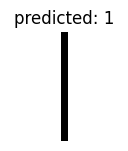

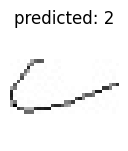

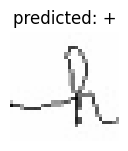

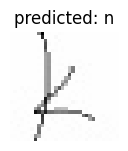

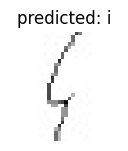

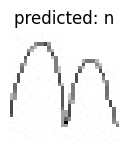

In [66]:
visualize_model(model_ft)

In [55]:
torch.save(model_ft, 'transfer_model_squeeze_net.pth')